All Necessary Imports

In [1]:
from tensorflow.keras import layers,Model,Sequential,Input
from tensorflow.keras.applications import ResNet152V2,InceptionResNetV2,VGG19,InceptionV3,MobileNetV2
from tensorflow.keras.applications import resnet_v2,inception_resnet_v2,vgg19,inception_v3,mobilenet_v2
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

Reading Training and Testing Data into DataFrame

In [2]:
train_data = pd.read_csv('train/train.csv')
test_data = pd.read_csv('test.csv')

Setting Image Shape and Number of Epochs

As here transfer learning is used the already trained models take an max input shape of (224,224)

In [3]:
IMG_WIDTH=224
IMG_HEIGHT=224
IMG_SHAPE = (IMG_HEIGHT,IMG_WIDTH,3)
EPOCHS = 50

Plots graph of Training loss vs Validation loss

In [4]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Loads the images into numpy array.

Also converts the Black and White Images from 1 Channel to 3 Channels

In [5]:
def create_training_dataset(img_folder):
    img_data_array=[]
    class_name=[]
    for index, row in train_data.iterrows():       
            image_path= os.path.join(img_folder,  row['Name'])
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            if image.shape != IMG_SHAPE:
                image = np.stack((image,)*3, axis=-1)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(row['HeadCount'])
    return np.array(img_data_array), np.array(class_name)

In [6]:
def create_test_dataset(img_folder):
    img_data_array=[]
    for index, row in test_data.iterrows():       
            image_path= os.path.join(img_folder,  row['Name'])
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            if image.shape != (224, 224, 3):
                image = np.stack((image,)*3, axis=-1)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
    return np.array(img_data_array)

This Function writes the final prediction into the submission file.

The final output is computed as the average of all the models prediction

In [7]:
def getFinalAvgPredictions(models,n=None):
    final_prediction_df = pd.DataFrame()
    for model in models:
        print(model," Loading...")
        loaded_model = load_model('Models/'+model)
        print("Model Load done")
        final_prediction_df[model] = loaded_model.predict(img_test_data).flatten()                                     
    final_prediction_df['predictions'] = final_prediction_df.mean(axis=1)
    final_pred = pd.DataFrame(columns=['Name','HeadCount'])
    final_pred['Name'] = test_data['Name']
    final_pred['HeadCount'] = final_prediction_df['predictions']
    if n != None:
        final_pred.to_csv('submission_'+str(n)+'.csv',index=False)
    else:
        final_pred.to_csv('submission'+'.csv',index=False)
    

                             

In [8]:
img_data, class_name =create_training_dataset(r'E:\Programming Work\Machine Learning\Face Counting\train\image_data')
img_test_data =create_test_dataset(r'E:\Programming Work\Machine Learning\Face Counting\train\image_data')

In [9]:
callbacks=EarlyStopping(monitor='val_loss', patience=4)

Using Data Augmentation to get different angles of human faces while training

In [10]:
data_augmentation = Sequential([
     layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
     layers.experimental.preprocessing.RandomRotation(0.4),
])

Creating and Training the model using the ResNet152V2 as a base model

Epoch 1/50
144/144 [==============================] - 30s 206ms/step - loss: 2.8496 - mean_absolute_error: 2.8496 - val_loss: 1.7645 - val_mean_absolute_error: 1.7645
Epoch 2/50
144/144 [==============================] - 27s 187ms/step - loss: 2.1090 - mean_absolute_error: 2.1090 - val_loss: 1.6056 - val_mean_absolute_error: 1.6056
Epoch 3/50
144/144 [==============================] - 27s 189ms/step - loss: 1.9728 - mean_absolute_error: 1.9728 - val_loss: 1.4661 - val_mean_absolute_error: 1.4661
Epoch 4/50
144/144 [==============================] - 27s 191ms/step - loss: 1.8437 - mean_absolute_error: 1.8437 - val_loss: 1.3990 - val_mean_absolute_error: 1.3990
Epoch 5/50
144/144 [==============================] - 28s 193ms/step - loss: 1.7441 - mean_absolute_error: 1.7441 - val_loss: 1.3632 - val_mean_absolute_error: 1.3632
Epoch 6/50
144/144 [==============================] - 28s 195ms/step - loss: 1.6843 - mean_absolute_error: 1.6843 - val_loss: 1.2996 - val_mean_absolute_error: 1.299

Epoch 50/50
144/144 [==============================] - 29s 199ms/step - loss: 0.8550 - mean_absolute_error: 0.8550 - val_loss: 1.0600 - val_mean_absolute_error: 1.0600
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Models/model_ResNet152V2\assets


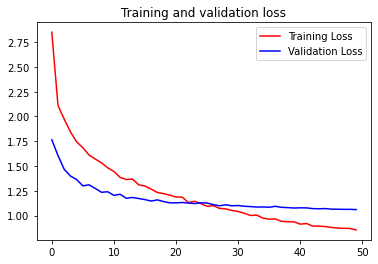

In [11]:
base_model_ResNet152V2 = ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model_ResNet152V2.trainable = False


last_layer_ResNet152V2 = base_model_ResNet152V2.get_layer("post_relu")
last_output_ResNet152V2 = last_layer_ResNet152V2.output




preprocess_input_ResNet152V2 =resnet_v2.preprocess_input

inputs = Input(shape=IMG_SHAPE)
x_ResNet152V2 = data_augmentation(inputs)
x_ResNet152V2 = preprocess_input_ResNet152V2(x_ResNet152V2)
x_ResNet152V2 = layers.Flatten()(last_output_ResNet152V2)
x_ResNet152V2 = layers.Dense(1024, activation='relu')(x_ResNet152V2)
x_ResNet152V2 = layers.Dropout(.2)(x_ResNet152V2)
x_ResNet152V2 = layers.Dense(512, activation='relu')(x_ResNet152V2)
x_ResNet152V2 = layers.Dropout(.2)(x_ResNet152V2) 
x_ResNet152V2 = layers.Dense(256, activation='relu')(x_ResNet152V2)
x_ResNet152V2 = layers.Dropout(.2)(x_ResNet152V2)                  
x_ResNet152V2 = layers.Dense(1)(x_ResNet152V2)      


model_ResNet152V2 = Model(base_model_ResNet152V2.input, x_ResNet152V2) 

model_ResNet152V2.compile(
    optimizer='Adadelta',
    loss='mean_absolute_error', 
    metrics=['mean_absolute_error']
)

history =model_ResNet152V2.fit(
    img_data, class_name,
    epochs=EPOCHS,
    verbose=1,
    validation_split = 0.2,
    callbacks=callbacks
)
model_ResNet152V2.save('Models/model_ResNet152V2')
plot_history(history)

Creating and Training the model using the InceptionResNetV2 as a base model

Epoch 1/50
144/144 [==============================] - 26s 179ms/step - loss: 2.4134 - mean_absolute_error: 2.4134 - val_loss: 1.6171 - val_mean_absolute_error: 1.6171
Epoch 2/50
144/144 [==============================] - 21s 147ms/step - loss: 1.8872 - mean_absolute_error: 1.8872 - val_loss: 1.4186 - val_mean_absolute_error: 1.4186
Epoch 3/50
144/144 [==============================] - 21s 148ms/step - loss: 1.7982 - mean_absolute_error: 1.7982 - val_loss: 1.4220 - val_mean_absolute_error: 1.4220
Epoch 4/50
144/144 [==============================] - 21s 149ms/step - loss: 1.7156 - mean_absolute_error: 1.7156 - val_loss: 1.3548 - val_mean_absolute_error: 1.3548
Epoch 5/50
144/144 [==============================] - 22s 153ms/step - loss: 1.6346 - mean_absolute_error: 1.6346 - val_loss: 1.3215 - val_mean_absolute_error: 1.3215
Epoch 6/50
144/144 [==============================] - 22s 154ms/step - loss: 1.5866 - mean_absolute_error: 1.5866 - val_loss: 1.2385 - val_mean_absolute_error: 1.238

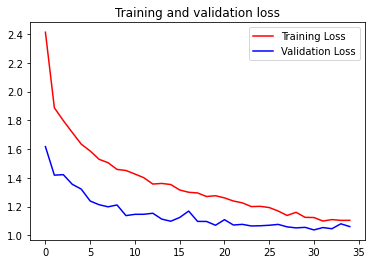

In [14]:
base_model_InceptionResNetV2 = InceptionResNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model_InceptionResNetV2.trainable = False


last_layer_InceptionResNetV2 = base_model_InceptionResNetV2.get_layer("conv_7b_ac")
last_output_InceptionResNetV2 = last_layer_InceptionResNetV2.output


preprocess_input_InceptionResNetV2 = inception_resnet_v2.preprocess_input

inputs = Input(shape=IMG_SHAPE)
x_InceptionResNetV2 = data_augmentation(inputs)
x_InceptionResNetV2 = preprocess_input_InceptionResNetV2(x_InceptionResNetV2)
x_InceptionResNetV2 = layers.Flatten()(last_output_InceptionResNetV2)
x_InceptionResNetV2 = layers.Dense(1024, activation='relu')(x_InceptionResNetV2)
x_InceptionResNetV2 = layers.Dropout(.2)(x_InceptionResNetV2)
x_InceptionResNetV2 = layers.Dense(512, activation='relu')(x_InceptionResNetV2)
x_InceptionResNetV2 = layers.Dropout(.2)(x_InceptionResNetV2) 
x_InceptionResNetV2 = layers.Dense(256, activation='relu')(x_InceptionResNetV2)
x_InceptionResNetV2 = layers.Dropout(.2)(x_InceptionResNetV2)                  
x_InceptionResNetV2 = layers.Dense(1)(x_InceptionResNetV2)      


model_InceptionResNetV2 = Model(base_model_InceptionResNetV2.input, x_InceptionResNetV2) 

model_InceptionResNetV2.compile(
    optimizer='Adadelta',
    loss='mean_absolute_error', 
    metrics=['mean_absolute_error']
)

history =model_InceptionResNetV2.fit(
    img_data, class_name,
    epochs=EPOCHS,
    verbose=1,
    validation_split = 0.2,
    callbacks=callbacks
)
model_InceptionResNetV2.save('Models/model_InceptionResNetV2')
plot_history(history)

Creating and Training the model using the VGG19 as a base model

Epoch 1/50
144/144 [==============================] - 18s 128ms/step - loss: 2.2772 - mean_absolute_error: 2.2772 - val_loss: 1.4574 - val_mean_absolute_error: 1.4574
Epoch 2/50
144/144 [==============================] - 17s 118ms/step - loss: 1.7043 - mean_absolute_error: 1.7043 - val_loss: 1.3971 - val_mean_absolute_error: 1.3971
Epoch 3/50
144/144 [==============================] - 17s 118ms/step - loss: 1.6585 - mean_absolute_error: 1.6585 - val_loss: 1.3357 - val_mean_absolute_error: 1.3357
Epoch 4/50
144/144 [==============================] - 17s 120ms/step - loss: 1.6221 - mean_absolute_error: 1.6221 - val_loss: 1.3001 - val_mean_absolute_error: 1.3001
Epoch 5/50
144/144 [==============================] - 17s 121ms/step - loss: 1.5743 - mean_absolute_error: 1.5743 - val_loss: 1.3061 - val_mean_absolute_error: 1.3061
Epoch 6/50
144/144 [==============================] - 18s 122ms/step - loss: 1.5634 - mean_absolute_error: 1.5634 - val_loss: 1.2818 - val_mean_absolute_error: 1.281

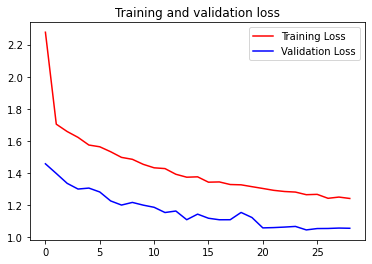

In [15]:
base_model_VGG19 = VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model_VGG19.trainable = False


last_layer_VGG19 = base_model_VGG19.get_layer("block5_pool")
last_output_VGG19 = last_layer_VGG19.output


preprocess_input_VGG19 = vgg19.preprocess_input

inputs = Input(shape=IMG_SHAPE)
x_VGG19 = data_augmentation(inputs)
x_VGG19 = preprocess_input_VGG19(x_VGG19)
x_VGG19 = layers.Flatten()(last_output_VGG19)
x_VGG19 = layers.Dense(1024, activation='relu')(x_VGG19)
x_VGG19 = layers.Dropout(.2)(x_VGG19)
x_VGG19 = layers.Dense(512, activation='relu')(x_VGG19)
x_VGG19 = layers.Dropout(.2)(x_VGG19) 
x_VGG19 = layers.Dense(256, activation='relu')(x_VGG19)
x_VGG19 = layers.Dropout(.2)(x_VGG19)                  
x_VGG19 = layers.Dense(1)(x_VGG19)      


model_VGG19 = Model(base_model_VGG19.input, x_VGG19) 

model_VGG19.compile(
    optimizer='Adadelta',
    loss='mean_absolute_error', 
    metrics=['mean_absolute_error']
)

history =model_VGG19.fit(
    img_data, class_name,
    epochs=EPOCHS,
    verbose=1,
    validation_split = 0.2,
    callbacks=callbacks
)

model_VGG19.save('Models/model_VGG19')
plot_history(history)

Creating and Training the model using the InceptionV3 as a base model

Epoch 1/50
144/144 [==============================] - 12s 86ms/step - loss: 2.2196 - mean_absolute_error: 2.2196 - val_loss: 1.4759 - val_mean_absolute_error: 1.4759
Epoch 2/50
144/144 [==============================] - 10s 70ms/step - loss: 1.7911 - mean_absolute_error: 1.7911 - val_loss: 1.4011 - val_mean_absolute_error: 1.4011
Epoch 3/50
144/144 [==============================] - 10s 70ms/step - loss: 1.6577 - mean_absolute_error: 1.6577 - val_loss: 1.3272 - val_mean_absolute_error: 1.3272
Epoch 4/50
144/144 [==============================] - 10s 71ms/step - loss: 1.5608 - mean_absolute_error: 1.5608 - val_loss: 1.3346 - val_mean_absolute_error: 1.3346
Epoch 5/50
144/144 [==============================] - 10s 71ms/step - loss: 1.5499 - mean_absolute_error: 1.5499 - val_loss: 1.2765 - val_mean_absolute_error: 1.2765
Epoch 6/50
144/144 [==============================] - 10s 72ms/step - loss: 1.4624 - mean_absolute_error: 1.4624 - val_loss: 1.3169 - val_mean_absolute_error: 1.3169
Epoc

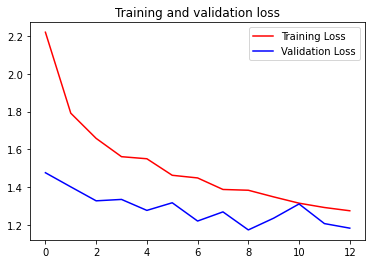

In [16]:
base_model_InceptionV3 = InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model_InceptionV3.trainable = False


last_layer_InceptionV3 = base_model_InceptionV3.get_layer("mixed10")
last_output_InceptionV3 = last_layer_InceptionV3.output


preprocess_input_InceptionV3 = inception_v3.preprocess_input

inputs = Input(shape=IMG_SHAPE)
x_InceptionV3 = data_augmentation(inputs)
x_InceptionV3 = preprocess_input_InceptionV3(x_InceptionV3)
x_InceptionV3 = layers.Flatten()(last_output_InceptionV3)
x_InceptionV3 = layers.Dense(1024, activation='relu')(x_InceptionV3)
x_InceptionV3 = layers.Dropout(.2)(x_InceptionV3)
x_InceptionV3 = layers.Dense(512, activation='relu')(x_InceptionV3)
x_InceptionV3 = layers.Dropout(.2)(x_InceptionV3) 
x_InceptionV3 = layers.Dense(256, activation='relu')(x_InceptionV3)
x_InceptionV3 = layers.Dropout(.2)(x_InceptionV3)                  
x_InceptionV3 = layers.Dense(1)(x_InceptionV3)      


model_InceptionV3 = Model(base_model_InceptionV3.input, x_InceptionV3) 

model_InceptionV3.compile(
    optimizer='Adadelta',
    loss='mean_absolute_error', 
    metrics=['mean_absolute_error']
)

history =model_InceptionV3.fit(
    img_data, class_name,
    epochs=EPOCHS,
    verbose=1,
    validation_split = 0.2,
    callbacks=callbacks
)
model_InceptionV3.save('Models/model_InceptionV3')
plot_history(history)

Creating and Training the model using the MobileNetV2 as a base model

Epoch 1/50
144/144 [==============================] - 8s 56ms/step - loss: 2.0321 - mean_absolute_error: 2.0321 - val_loss: 1.3389 - val_mean_absolute_error: 1.3389
Epoch 2/50
144/144 [==============================] - 7s 46ms/step - loss: 1.7530 - mean_absolute_error: 1.7530 - val_loss: 1.2215 - val_mean_absolute_error: 1.2215
Epoch 3/50
144/144 [==============================] - 7s 46ms/step - loss: 1.6095 - mean_absolute_error: 1.6095 - val_loss: 1.1822 - val_mean_absolute_error: 1.1822
Epoch 4/50
144/144 [==============================] - 7s 47ms/step - loss: 1.5271 - mean_absolute_error: 1.5271 - val_loss: 1.1248 - val_mean_absolute_error: 1.1248
Epoch 5/50
144/144 [==============================] - 7s 47ms/step - loss: 1.4532 - mean_absolute_error: 1.4532 - val_loss: 1.1003 - val_mean_absolute_error: 1.1003
Epoch 6/50
144/144 [==============================] - 7s 47ms/step - loss: 1.4220 - mean_absolute_error: 1.4220 - val_loss: 1.0686 - val_mean_absolute_error: 1.0686
Epoch 7/50

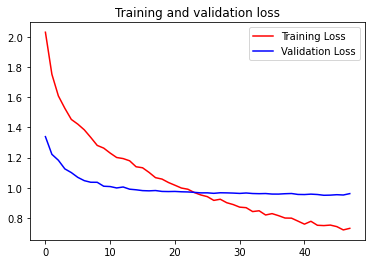

In [17]:
base_model_MobileNetV2 = MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model_MobileNetV2.trainable = False


last_layer_MobileNetV2 = base_model_MobileNetV2.get_layer("out_relu")
last_output_MobileNetV2 = last_layer_MobileNetV2.output



preprocess_input_MobileNetV2 = mobilenet_v2.preprocess_input

inputs = Input(shape=IMG_SHAPE)
x_MobileNetV2 = data_augmentation(inputs)
x_MobileNetV2 = preprocess_input_MobileNetV2(x_MobileNetV2)
x_MobileNetV2 = layers.Flatten()(last_output_MobileNetV2)
x_MobileNetV2 = layers.Dense(1024, activation='relu')(x_MobileNetV2)
x_MobileNetV2 = layers.Dropout(.2)(x_MobileNetV2)
x_MobileNetV2 = layers.Dense(512, activation='relu')(x_MobileNetV2)
x_MobileNetV2 = layers.Dropout(.2)(x_MobileNetV2) 
x_MobileNetV2 = layers.Dense(256, activation='relu')(x_MobileNetV2)
x_MobileNetV2 = layers.Dropout(.2)(x_MobileNetV2)                  
x_MobileNetV2 = layers.Dense(1)(x_MobileNetV2)      


model_MobileNetV2 = Model(base_model_MobileNetV2.input, x_MobileNetV2) 

model_MobileNetV2.compile(
    optimizer='Adadelta',
    loss='mean_absolute_error', 
    metrics=['mean_absolute_error']
)

history =model_MobileNetV2.fit(
    img_data, class_name,
    epochs=EPOCHS,
    verbose=1,
    validation_split = 0.2,
    callbacks=callbacks
)
model_MobileNetV2.save('Models/model_MobileNetV2')
plot_history(history)

In [10]:
model_names = ['model_MobileNetV2','model_InceptionV3','model_VGG19','model_InceptionResNetV2','model_ResNet152V2']

In [11]:
getFinalAvgPredictions(model_names,14)

model_MobileNetV2  Loading...
Model Load done
model_InceptionV3  Loading...
Model Load done
model_VGG19  Loading...
Model Load done
model_InceptionResNetV2  Loading...
Model Load done
model_ResNet152V2  Loading...
Model Load done
